# Regression Week 3: Assessing Fit (polynomial regression)

In this notebook you will compare different regression models in order to assess which model fits best. We will be using polynomial regression as a means to examine this topic. In particular you will:
* Write a function to take an SArray and a degree and return an SFrame where each column is the SArray to a polynomial value up to the total degree e.g. degree = 3 then column 1 is the SArray column 2 is the SArray squared and column 3 is the SArray cubed
* Use matplotlib to visualize polynomial regressions
* Use matplotlib to visualize the same polynomial degree on different subsets of the data
* Use a validation set to select a polynomial degree
* Assess the final fit using test data

We will continue to use the House data from previous notebooks.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as pl
import seaborn as sns

C:\Users\Home\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%matplotlib inline

Next we're going to write a polynomial function that takes an SArray and a maximal degree and returns an SFrame with columns containing the SArray to all the powers up to the maximal degree.

The easiest way to apply a power to an SArray is to use the .apply() and lambda x: functions. 
For example to take the example array and compute the third power we can do as follows: (note running this cell the first time may take longer than expected since it loads graphlab)

In [3]:
tmp =  pd.DataFrame(np.array([1., 2., 3.]))
tmp_cubed = tmp.apply(lambda x: x**3)
print tmp
print tmp_cubed

   0
0  1
1  2
2  3
    0
0   1
1   8
2  27


We can create an empty SFrame using graphlab.SFrame() and then add any columns to it with ex_sframe['column_name'] = value. For example we create an empty SFrame and make the column 'power_1' to be the first power of tmp (i.e. tmp itself).

In [4]:
ex_sframe = tmp.copy()
print ex_sframe

   0
0  1
1  2
2  3


# Polynomial_sframe function

Using the hints above complete the following function to create an SFrame consisting of the powers of an SArray up to a specific degree:

In [6]:
def polynomial_df(feature, degree):
    # assume that degree >= 1
    # initialize the SFrame:
    poly_df = pd.DataFrame(feature)
    # and set poly_sframe['power_1'] equal to the passed feature
    poly_df.columns = ['power_1']
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_sframe[name] to the appropriate power of feature
            poly_df[name] = poly_df.power_1.apply(lambda x : x ** power)

    return poly_df

To test your function consider the smaller tmp variable and what you would expect the outcome of the following call:

In [6]:
print polynomial_df(tmp, 3)

   power_1  power_2  power_3
0        1        1        1
1        2        4        8
2        3        9       27


# Visualizing polynomial regression

Let's use matplotlib to visualize what a polynomial regression looks like on some real data.

In [2]:
dtype_dict = {'bathrooms': float, 'waterfront': int, 'sqft_above': int,
                  'sqft_living15': float, 'grade': int, 'yr_renovated': int,
                  'price': float, 'bedrooms': float, 'zipcode': str,
                  'long': float, 'sqft_lot15': float, 'sqft_living': float,
                  'floors': str, 'condition': int, 'lat': float, 'date': str,
                  'sqft_basement': int, 'yr_built': int, 'id': str,
                  'sqft_lot': int, 'view': int}

In [8]:
train = pd.read_csv("kc_house_train_data.csv", dtype=dtype_dict)
test = pd.read_csv('kc_house_test_data.csv', dtype=dtype_dict)
train['is_test'] = False
test['is_test'] = True
sales = pd.concat([train, test])

As in Week 3, we will use the sqft_living variable. For plotting purposes (connecting the dots), you'll need to sort by the values of sqft_living. For houses with identical square footage, we break the tie by their prices.

In [9]:
sales = sales.sort(['sqft_living', 'price'])

Let's start with a degree 1 polynomial using 'sqft_living' (i.e. a line) to predict 'price' and plot what it looks like.

In [10]:
poly1_data = polynomial_df(sales['sqft_living'], 1)
poly1_data['price'] = sales['price'] # add price to the data since it's the target

In [11]:
# create helper function to build modles
def make_mod(df,depvar, invar):
    X = df[invar]
    y = df[depvar]
    X = sm.add_constant(X)
    mod = sm.OLS(y,X).fit()
    return mod

In [12]:
mod1 = make_mod(poly1_data, 'price', 'power_1')

In [13]:
#let's take a look at the weights before we plot
mod1.params

const     -43580.743094
power_1      280.623568
dtype: float64

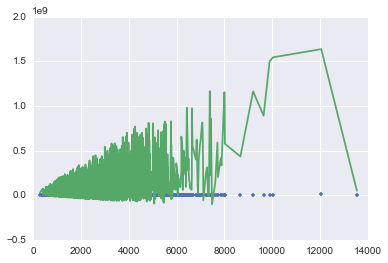

In [14]:
pl.plot(poly1_data['power_1'],poly1_data['price'],'.',
        poly1_data['power_1'], mod1.predict(poly1_data),'-')

Let's unpack that plt.plot() command. The first pair of SArrays we passed are the 1st power of sqft and the actual price we then ask it to print these as dots '.'. The next pair we pass is the 1st power of sqft and the predicted values from the linear model. We ask these to be plotted as a line '-'. 

We can see, not surprisingly, that the predicted values all fall on a line, specifically the one with slope 280 and intercept -43579. What if we wanted to plot a second degree polynomial?

In [15]:
poly2_data = polynomial_df(sales['sqft_living'], 2)
my_features = poly2_data.columns[0:2] # get the name of the features
poly2_data['price'] = sales['price'] # add price to the data since it's the target
mod2 = make_mod(poly2_data, 'price', my_features)

In [16]:
mod2.params

const      199222.279306
power_1        67.994095
power_2         0.038581
dtype: float64

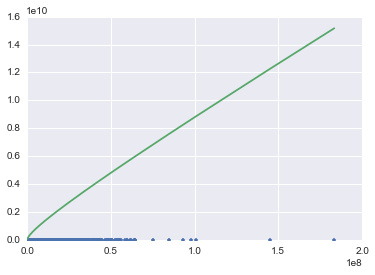

In [17]:
pl.plot(poly2_data['power_2'],poly2_data['price'],'.',
        poly2_data['power_2'], mod2.predict(poly2_data),'-')

The resulting model looks like half a parabola. Try on your own to see what the cubic looks like:

In [18]:
poly3_data = polynomial_df(sales['sqft_living'], 3)
my_features = poly3_data.columns # get the name of the features
poly3_data['price'] = sales['price'] # add price to the data since it's the target
mod3 = make_mod(poly3_data, 'price', my_features)

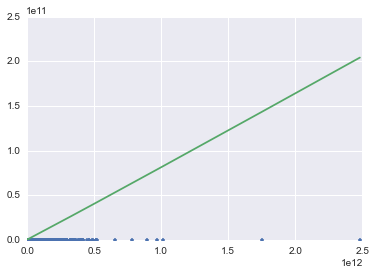

In [19]:
pl.plot(poly3_data['power_3'],poly3_data['price'],'.',
        poly3_data['power_3'], mod3.predict(poly3_data),'-')

Now try a 15th degree polynomial:

In [20]:
poly15_data = polynomial_df(sales['sqft_living'], 15)
my_features = poly15_data.columns # get the name of the features
poly15_data['price'] = sales['price'] # add price to the data since it's the target
mod15 = make_mod(poly15_data, 'price', my_features)

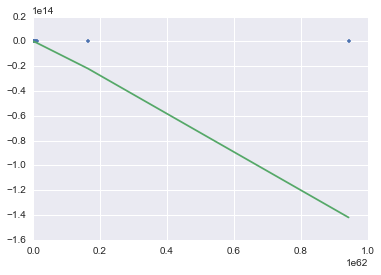

In [21]:
pl.plot(poly15_data['power_15'],poly15_data['price'],'.',
        poly15_data['power_15'], mod15.predict(poly15_data),'-')

What do you think of the 15th degree polynomial? Do you think this is appropriate? If we were to change the data do you think you'd get pretty much the same curve? Let's take a look.

# Changing the data and re-learning

We're going to split the sales data into four subsets of roughly equal size. Then you will estimate a 15th degree polynomial model on all four subsets of the data. Print the coefficients (you should use .print_rows(num_rows = 16) to view all of them) and plot the resulting fit (as we did above). The quiz will ask you some questions about these results.

To split the sales data into four subsets, we perform the following steps:
* First split sales into 2 subsets with `.random_split(0.5, seed=0)`. 
* Next split the resulting subsets into 2 more subsets each. Use `.random_split(0.5, seed=0)`.

We set `seed=0` in these steps so that different users get consistent results.
You should end up with 4 subsets (`set_1`, `set_2`, `set_3`, `set_4`) of approximately equal size. 

In [3]:
set_1 = pd.read_csv("wk3_kc_house_set_1_data.csv", dtype = dtype_dict)
set_2 = pd.read_csv("wk3_kc_house_set_2_data.csv", dtype = dtype_dict)
set_3 = pd.read_csv("wk3_kc_house_set_3_data.csv", dtype = dtype_dict)
set_4 = pd.read_csv("wk3_kc_house_set_4_data.csv", dtype = dtype_dict)

In [4]:
set_1.index.name = 'set_1'
set_2.index.name = 'set_2'
set_3.index.name = 'set_3'
set_4.index.name = 'set_4'

Fit a 15th degree polynomial on set_1, set_2, set_3, and set_4 using sqft_living to predict prices. Print the coefficients and make a plot of the resulting model.

In [7]:
data_sets = [set_1, set_2, set_3, set_4]

sets = []

for s in data_sets: 
    s['df_name'] = s.index.name
    p_df = polynomial_df(s['sqft_living'], 15)
    p_df['price'] = s.price
    sets.append(p_df)

In [8]:
## fit a polynomial and then return the model
def fit_poly(set_number) :
    df = pd.DataFrame(sets[set_number])
    df = df.reset_index()
    X = df[df.columns[:-1]]
    y = df['price']
    X = sm.add_constant(X)
    mod = sm.OLS(y,X).fit()
    return mod

In [9]:
set_1mod = fit_poly(0)
set_2mod = fit_poly(1)
set_3mod = fit_poly(2)
set_4mod = fit_poly(3)

In [13]:
pd.concat([set_1mod.params, set_2mod.params, set_3mod.params, set_4mod.params],1)

,0,1,2,3
const,6.998479e-94,3.517945e-90,9.177576e-92,1.071068e-79
power_1,-1.080836e-54,1.734241e-53,-9.974575e-55,2.192419e-44
power_10,3.787194e-55,6.021428e-53,7.159580e-54,9.021288e-44
power_11,2.365357e-51,2.627828e-49,3.624982e-50,2.293589e-40
power_12,1.249831e-47,9.660086e-46,1.545534e-46,3.687437e-37
power_13,4.466425e-44,2.391397e-42,4.435903e-43,-1.549726e-40
power_14,-6.956928e-48,-5.717156e-46,-8.990862e-47,2.162990e-44
power_15,2.702043e-52,3.390889e-50,4.562005e-51,-1.002357e-48
power_2,4.958728e-60,7.964952e-58,-1.477453e-58,2.339335e-49
power_3,3.026568e-64,8.102368e-63,2.890864e-79,-4.093992e-53


In [27]:
# plot ploynomial models
def plot_poly(set_number, mod) :
    df = pd.DataFrame(sets[set_number])
    df = df.reset_index()
    pl.plot(df['power_15'], df['price'],'.', df['power_15'], mod.predict(df),'-')

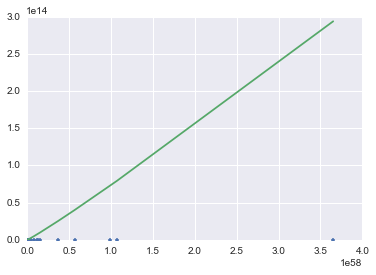

In [28]:
#plot_poly(0, set_1mod)
#plot_poly(1, set_2mod)
#plot_poly(2,set3_mod)
plot_poly(3, set_4mod)

In [29]:
print "mod1" , set_1mod.params[14]
print "mod2" , set_2mod.params[14]
print "mod3" , set_3mod.params[14]
print "mod4" , set_4mod.params[14]

mod1 4.46642527907e-44
mod2 2.39139658864e-42
mod3 4.43590334942e-43
mod4 -1.54972601078e-40


Some questions you will be asked on your quiz:

**Quiz Question: Is the sign (positive or negative) for power_15 the same in all four models?**

**Quiz Question: (True/False) the plotted fitted lines look the same in all four plots**

# Selecting a Polynomial Degree

Whenever we have a "magic" parameter like the degree of the polynomial there is one well-known way to select these parameters: validation set. (We will explore another approach in week 4).

We split the sales dataset 3-way into training set, test set, and validation set as follows:

* Split our sales data into 2 sets: `training_and_validation` and `testing`. Use `random_split(0.9, seed=1)`.
* Further split our training data into two sets: `training` and `validation`. Use `random_split(0.5, seed=1)`.

Again, we set `seed=1` to obtain consistent results for different users.

In [35]:
valid = pd.read_csv("wk3_kc_house_valid_data.csv", dtype = dtype_dict)
train = pd.read_csv("kc_house_train_data.csv", dtype=dtype_dict)
test = pd.read_csv('kc_house_test_data.csv', dtype=dtype_dict)

Next you should write a loop that does the following:
* For degree in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] (to get this in python type range(1, 15+1))
    * Build an SFrame of polynomial data of train_data['sqft_living'] at the current degree
    * hint: my_features = poly_data.column_names() gives you a list e.g. ['power_1', 'power_2', 'power_3'] which you might find useful for graphlab.linear_regression.create( features = my_features)
    * Add train_data['price'] to the polynomial SFrame
    * Learn a polynomial regression model to sqft vs price with that degree on TRAIN data
    * Compute the RSS on VALIDATION data (here you will want to use .predict()) for that degree and you will need to make a polynmial SFrame using validation data.
* Report which degree had the lowest RSS on validation data (remember python indexes from 0)

(Note you can turn off the print out of linear_regression.create() with verbose = False)

In [106]:
degrees =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for d in degrees:
    tr = polynomial_df(train['sqft_living'], d)
    val = polynomial_df(valid['sqft_living'], d)

In [107]:
tr['price'] = train.price
val['price'] = valid.price

In [108]:
poly_models = {}

for d in degrees:
    mod_name =  'poly_' + str(d)
    features = tr.ix[:,:d].columns
    poly_models[mod_name] = make_mod(tr, 'price',features)

**Quiz Question: Which degree (1, 2, …, 15) had the lowest RSS on Validation data?**

Now that you have chosen the degree of your polynomial using validation data, compute the RSS of this model on TEST data. Report the RSS on your quiz.

In [116]:
def get_poly_RSS(degree) :
    mod_name = 'poly_' + str(degree)
    X = val.ix[:,:degree]
    X = sm.add_constant(X)
    preds = poly_models[mod_name].predict(X)
    RSS = sum((val.price - preds)**2)
    return RSS

In [121]:
for d in degrees:
    print "poly",d , "RSS :",get_poly_RSS(d)

poly 1 RSS : 6.27643406474e+14
poly 2 RSS : 6.00516989421e+14
poly 3 RSS : 5.79497985835e+14
poly 4 RSS : 5.75484342256e+14
poly 5 RSS : 6.23572080404e+14
poly 6 RSS : 8.08930739801e+14
poly 7 RSS : 1.21973416085e+15
poly 8 RSS : 1.8335888603e+15
poly 9 RSS : 2.48291969282e+15
poly 10 RSS : 2.99141809902e+15
poly 11 RSS : 3.73445816484e+15
poly 12 RSS : 3.79240589713e+15
poly 13 RSS : 3.82515830449e+15
poly 14 RSS : 3.84535650537e+15
poly 15 RSS : 3.85900950418e+15


**Quiz Question: what is the RSS on TEST data for the model with the degree selected from Validation data? (Make sure you got the correct degree from the previous question)**

In [126]:
X = polynomial_df(test['sqft_living'], 7)
y = test.price
X = sm.add_constant(X)

In [128]:
sum((y - poly_models['poly_7'].predict(X))**2)

526897025698913.44

In [129]:
RSS = {}
RSS_Test = {}

In [137]:
def polynomial_df(feature, degree):
    new_df = pd.DataFrame()
    new_df['power_1'] = np.array(feature)
    if degree > 1:
        for power in range(2, degree+1):
            name = 'power_' + str(power)
            new_df[name] = np.array(feature)**power
    return new_df

In [138]:
from sklearn.linear_model import LinearRegression

In [139]:
for i in range(1, 15+1):
    poly_data = polynomial_df(train['sqft_living'], i)
    regressor = LinearRegression(fit_intercept=True)
    X = np.array(poly_data)
    y = np.array(train['price'])
    model = regressor.fit(X,y)
    
    valid_x = np.array(polynomial_df(valid['sqft_living'], i))
    valid_y = np.array(valid['price'])
    RSS[str(i)] = np.sum((model.predict(valid_x) - valid_y) **2)
    
    test_x = np.array(polynomial_df(test['sqft_living'], i))
    test_y = np.array(test['price'])
    RSS_Test[str(i)] = np.sum((model.predict(test_x) - test_y)**2)
    
print("Degree", min(RSS, key = RSS.get), "has the lowest RSS")   
print(RSS_Test[str(min(RSS, key=RSS.get))])      

('Degree', '6', 'has the lowest RSS')
2.50578399348e+14


In [148]:
X = poly_data.ix[:,:6]
X = sm.add_constant(X)
mod = sm.OLS(y,X).fit()

In [149]:
tst_X = polynomial_df(test['sqft_living'], 6)

In [150]:
tst_X = sm.add_constant(tst_X)

In [152]:
np.sum((test.price - mod.predict(tst_X))**2)

348001179183242.25

https://github.com/TimButters/Coursera-Regression/blob/master/Week3/polynomial_regression.py